<a href="https://colab.research.google.com/github/Aliubit/ADM-HW-1-2020-/blob/main/NNDS_2021_Exercise2_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 2 (Solution)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers, initializers, losses, optimizers, metrics

In [ ]:
import matplotlib.pyplot as plt
import tqdm

In [ ]:
# We load the dataset
%pip install tfds-nightly

     |████████████████████████████████| 4.0 MB 37.2 MB/s 


In [ ]:
import tensorflow_datasets as tfds
train_data = tfds.load('penguins', split='train[:75%]')
test_data = tfds.load('penguins', split='train[75%:]')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling penguins-train.tfrecord...:   0%|          | 0/334 [00:00<?, ? examples/s]

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


## 1: Modifying the initialization method

In [ ]:
# Like in many modules, we have functional and object-oriented versions of the initializers: we show both here.
model = Sequential([
     layers.Dense(12, activation='relu', kernel_initializer=initializers.GlorotNormal(), bias_initializer=initializers.Ones()),
     layers.Dense(3, kernel_initializer=initializers.glorot_normal, bias_initializer=initializers.ones)       
])

In [ ]:
# We feed a batch of data and check the biases
_ = model(tf.random.normal((1, 4)))
print(model.trainable_variables[1])

<tf.Variable 'dense/bias:0' shape=(12,) dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>


## Rewriting the optimization loop

In [ ]:
cross_entropy = losses.SparseCategoricalCrossentropy(from_logits=True)
adam = optimizers.Adam()

In [ ]:
@tf.function
def train_model(data):

    X, y = data['features'], data['species']

    with tf.GradientTape() as tape:
        # Compute the outputs of the model
        yhat = model(X)

        # Compute the loss
        loss = cross_entropy(y, yhat)

    # --> This is the major modification <--
    adam.minimize(loss, var_list=model.trainable_variables, tape=tape)

    return loss

In [ ]:
loss_history = []
for epoch in tqdm.tqdm(range(50)):
    for batch in train_data.shuffle(1000).batch(8):
        loss_history.append(train_model(batch).numpy())

100%|██████████| 50/50 [00:03<00:00, 15.63it/s]


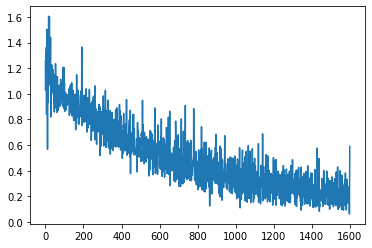

In [ ]:
plt.plot(loss_history)

In [ ]:
# This is a variant, where we replace the computation of the loss with a single callable.
# However, returning the loss here is non trivial.
@tf.function
def train_model_v2(data):

    X, y = data['features'], data['species']

    # --> This is now a callable without arguments <--
    loss = lambda: cross_entropy(y, model(X))

    # --> The list of variables must also be a callable with no arguments <--
    adam.minimize(loss, var_list=lambda: model.trainable_variables)

In [ ]:
for epoch in tqdm.tqdm(range(50)):
    for batch in train_data.shuffle(1000).batch(8):
        train_model_v2(batch)

100%|██████████| 50/50 [00:02<00:00, 17.57it/s]


## Exercise 3: Writing a custom training loop for `tf.keras.Model`

In [ ]:
class CustomModel(Model):
    def __init__(self, num_hidden_units=12):
      super().__init__() # --> This is just boilerplate for subclassing
      # We define all necessary layers during initialization
      self.hidden_layer = layers.Dense(12, activation='relu')
      self.output_layer = layers.Dense(3)

    def __call__(self, X):
      # We manually call the layers in sequence
      return self.output_layer(
          self.hidden_layer(X)
      )

    def train_step(self, data):
      # This is an adaptation of train_model from the lab session.

      X, y = data['features'], data['species']

      with tf.GradientTape() as tape:
          # Compute the outputs of the model (using self now)
          yhat = self(X)

          # Compute the loss (with is now a parameter of the compiled model)
          loss = self.compiled_loss(y, yhat)

      # Compute the gradients of the loss (also with respect to self)
      grads = tape.gradient(loss, self.trainable_variables)

      # Apply the gradients
      adam.apply_gradients(zip(grads, self.trainable_variables))

      # Because we are running inside fit(), we also update all metrics and return them.
      # This also includes the loss.
      self.compiled_metrics.update_state(y, yhat)
      return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
      # We need this function to evaluate the model on the validation_data:
      # # https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#providing_your_own_evaluation_step
      
      X, y = data['features'], data['species']
      yhat = self(X)
      
      # We compute the same metrics as in the train_step
      self.compiled_loss(y, yhat)
      self.compiled_metrics.update_state(y, yhat)
      return {m.name: m.result() for m in self.metrics}

In [ ]:
model = CustomModel()

In [ ]:
model.compile(loss=cross_entropy, optimizer=adam, metrics=[accuracy])

In [ ]:
# We can now use our data without splitting X and y. :-)
model.fit(
    train_data.shuffle(1000).batch(8), 
    epochs=50,
    validation_data=test_data.batch(8)
)

Epoch 1/50
32/32 [==============================] - 1s 7ms/step - loss: 1.0357 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.8614 - val_sparse_categorical_accuracy: 0.8333
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.8447 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.7011 - val_sparse_categorical_accuracy: 0.8690
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.7258 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.6057 - val_sparse_categorical_accuracy: 0.8690
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.5286 - val_sparse_categorical_accuracy: 0.8690
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.4793 - val_sparse_categorical_accuracy: 0.8690
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.5265 - sparse_categorical_accuracy: 